# Setup

In [33]:
# Data-handling imports
import pandas as pd

# Text-handling imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Graphing libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Random seed
seed = 5993

In [34]:
# Run this once to download VADER lexicon (Hutto & Gilbert 2014)
# import nltk
# nltk.download('vader_lexicon')

In [64]:
# User options
cities = ["Texas", "New York"]
regexes = ["^(?:Texas|TX)", "^(?:NYC|New York|Bronx|Manhattan|Brooklyn|Queens|Staten Island)"]
colors = {
    "Texas": "#1f77b4",
    "New York": "#ff7f0e"
} # pulled from default matplotlib colors

# Keywords to plot separately
keywords = {
    "Texas": ["Abbott", "Trump", "Fauci", "CDC"],
    "New York": ["Cuomo", "Trump", "Fauci", "CDC"],
}

# Events to add to plot: (date, text, height from -100 to 100)
events = [
    ("2020-03-01", "First reported\ncase in US", 40)
]

# Data import & cleaning

In [65]:
# Read in data
df = pd.read_csv("../data/COVID.csv")

In [66]:
dfs = {}
for city, regex in zip(cities, regexes):
    # Create data frame
    dfs[city] = pd.DataFrame()
    
    # Subset original data
    mask = df["Tweet Location"].str.contains(regex, na=False)
    
    # Add columns
    dfs[city]["id"] = df[mask]["Tweet Id"]
    dfs[city]["text"] = df[mask]["Tweet Content"]
    dfs[city]["city"] = city
    dfs[city]["time"] = pd.to_datetime(df[mask]["Tweet Posted Time (UTC)"])
    
    #dfs[city].set_index("id", inplace=True)

# Compile dataframe with text
covid = pd.concat(dfs).reset_index(drop=True)
covid.set_index("id", inplace=True)

In [67]:
# Check if we're balanced across cities
covid["city"].value_counts(normalize=True) * 100

New York    81.323372
Texas       18.676628
Name: city, dtype: float64

# Sentiment analysis

In [68]:
# Instantiate sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiments
sentiments = pd.DataFrame([analyzer.polarity_scores(text) for text in covid["text"]])

# Append to original data frame
covid = pd.concat([covid, sentiments.set_index(covid.index)], axis=1)

# Graphs

In [69]:
def plt_setup(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=28)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

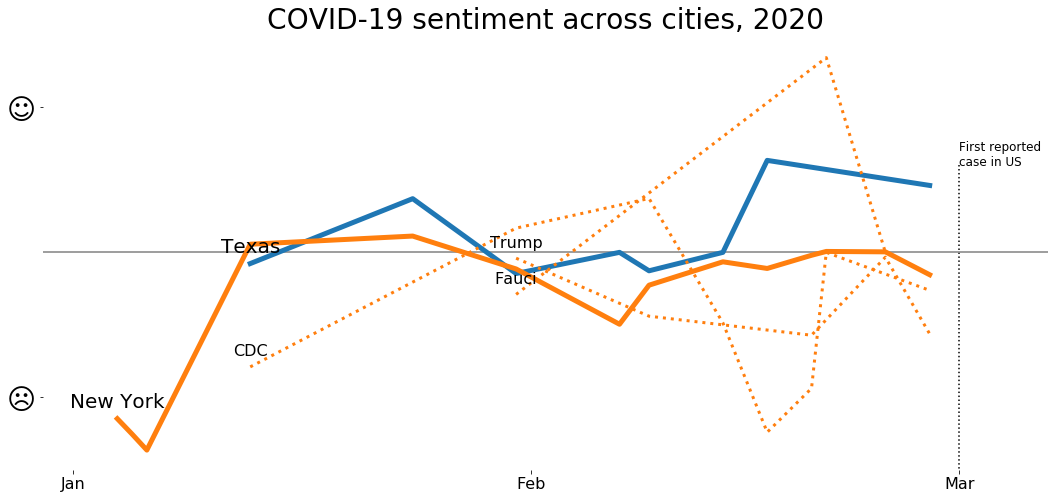

In [70]:
# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax,
         "COVID-19 sentiment across cities, 2020",
         "",
         ""
         )
ax.xaxis_date()
ax.set_xlim(("2019-12-30", "2020-03-07"))
ax.set_xticks(["2020-01-01", "2020-02-01", "2020-03-01"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.set_ylim((-100, 100))
ax.set_yticks([-66.667, 66.667])
ax.set_yticklabels(["☹", "☺"], fontsize=28)

ax.axhline(0, color="gray")

for city in cities:
    
    # Gather data
    subset = covid[covid["city"] == city]
    subset_mean = subset.groupby(subset["time"].dt.date).mean()

    # Draw line plot
    ax.plot(
        subset_mean.index,
        subset_mean["compound"] * 100,
        linewidth = 5,
        label = city,
        color = colors[city]
    );
    ax.text(
        x = subset_mean.index[0],
        y = subset_mean["compound"][0] * 100 + 5,
        s = city,
        fontsize = 20,
        horizontalalignment = "center"
    )
    
    for keyword in keywords[city]:
        # Gather data
        subset = covid[
            (covid["city"] == city) &
            (covid["text"].str.contains(keyword))
        ]
        subset_mean = subset.groupby(subset["time"].dt.date).mean()
        
        # Draw line plot
        if subset_mean.shape[0] > 2:
            ax.plot(
                subset_mean.index,
                subset_mean["compound"] * 100,
                linewidth = 3,
                linestyle = ":",
                color = colors[city]
            );
            ax.text(
                x = subset_mean.index[0],
                y = subset_mean["compound"][0] * 100 + 5,
                s = keyword,
                fontsize = 16,
                horizontalalignment = "center"
            )

# Annotate with events
for event in events:
    ax.text(
        x = pd.to_datetime(event[0]),
        y = event[2],
        s = event[1],
        fontsize = 12
    )
    ax.vlines(
        x = pd.to_datetime(event[0]),
        ymin = event[2],
        ymax = -100,
        linestyle = ":"
    )

# ax.legend(fontsize=20);

# References

Hutto, C. J. and Gilbert, E. E. Aug. 2014. [VADER: A parsimonious rule-based model for sentiment analysis of social media text.](http://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/view/8109) In Adar, E., Resnick, P., Choudhury, M. D., Hogan, B., and Oh, A. H., eds., *Proceedings of the Eighth International Conference on Weblogs and Social Media*, pp. 216–225. Palo Alto, CA: AAAI Press